Notebook for initial development and testing for synthesizing FA models.

The user specifies a number of individuals we observe data from.  For each of these individuals, we create a random number of observed variables (e.g., neurons) and associate with each of these variables some random properties (e.g., position or genetic information) generated uniformly from the unit square. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.decomposition
import torch

from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondGammaDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import Tanh
from janelia_core.visualization.image_generation import generate_2d_fcn_image
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from janelia_core.ml.utils import torch_mod_to_fcn

from probabilistic_model_synthesis.fa import FAMdl
from probabilistic_model_synthesis.fa import Fitter
from probabilistic_model_synthesis.fa import generate_basic_posteriors
from probabilistic_model_synthesis.fa import generate_simple_prior_collection
from probabilistic_model_synthesis.fa import VICollection

## Parameters go here

In [3]:
# Number of individuals we simulate observing data from 
n_individuals = 3

# Range of the number of variables we observe from each individual - the actual number of variables we observe from an
# individual will be pulled uniformly from this range (inclusive)
n_var_range = [100, 120]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [1000, 1500]

# Number of latent variables in the model
n_latent_vars = 3

# Min private variance
min_private_var = .1

## Create the true prior distributions that relate parameters in the model to variable (e.g., neuron) properties

In [4]:
true_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars)

### Visualize paraemters of the true prior distributions over the loading matrices

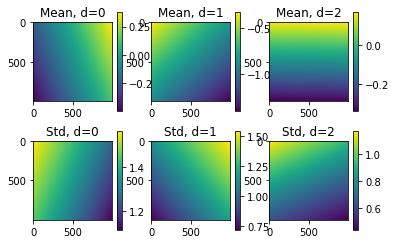

In [5]:
true_loadings_mn_f = true_priors.lm_prior.mn_f
true_loadings_std_f = true_priors.lm_prior.std_f

plt.figure()
for latent_d in range(n_latent_vars):
    mn_im, _, _ = generate_2d_fcn_image(torch_mod_to_fcn(true_loadings_mn_f), vis_dim=latent_d)
    std_im, _, _ = generate_2d_fcn_image(torch_mod_to_fcn(true_loadings_std_f), vis_dim=latent_d)
    
    ax = plt.subplot(2, n_latent_vars, latent_d+1)
    plt.imshow(mn_im)
    plt.colorbar()
    plt.title('Mean, d=' + str(latent_d))
    
    ax = plt.subplot(2, n_latent_vars, latent_d+1 + n_latent_vars)
    plt.imshow(std_im)
    plt.colorbar()
    plt.title('Std, d=' + str(latent_d))

### Visualize parameters of the true prior distribution over the means

Text(0.5, 1.0, 'Std')

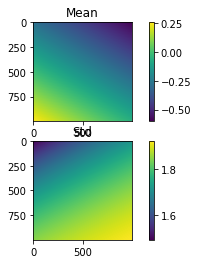

In [6]:
true_means_mn_f = true_priors.mn_prior.mn_f
true_means_std_f = true_priors.mn_prior.std_f

plt.figure()

mn_im, _, _ = generate_2d_fcn_image(torch_mod_to_fcn(true_means_mn_f))
std_im, _, _ = generate_2d_fcn_image(torch_mod_to_fcn(true_means_std_f))

ax = plt.subplot(2, 1, 1)
plt.imshow(mn_im)
plt.colorbar()
plt.title('Mean')

ax = plt.subplot(2, 1, 2)
plt.imshow(std_im)
plt.colorbar()
plt.title('Std')

### Visualize parameters of the true prior distribution over private variances

Text(0.5, 1.0, 'Sigma')

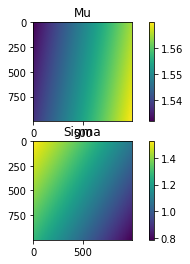

In [7]:
true_psi_mu_f = true_priors.psi_prior.mu_f
true_psi_sigma_f = true_priors.psi_prior.sigma_f

mu_im, _, _ = generate_2d_fcn_image(torch_mod_to_fcn(true_psi_mu_f))
sigma_im, _, _ = generate_2d_fcn_image(torch_mod_to_fcn(true_psi_sigma_f))

plt.figure()

ax = plt.subplot(2, 1, 1)
plt.imshow(mu_im)
plt.colorbar()
plt.title('Mu')

ax = plt.subplot(2, 1, 2)
plt.imshow(sigma_im)
plt.colorbar()
plt.title('Sigma')

## Generate properties

In [8]:
ind_n_vars = np.random.randint(n_var_range[0], n_var_range[1]+1, n_individuals)
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)

In [9]:
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

## Generate true FA models

In [10]:
with torch.no_grad():
    ind_true_fa_mdls = [FAMdl(lm=true_priors.lm_prior.sample(props), mn=true_priors.mn_prior.sample(props).squeeze(), 
                           psi=(true_priors.psi_prior.sample(props).squeeze() + min_private_var))
                        for props in ind_props]

## Generate data from each model

In [11]:
with torch.no_grad():
    ind_data = [mdl.sample(n_smps) for n_smps, mdl in zip(ind_n_smps, ind_true_fa_mdls)]

## Fit new models together

In [12]:
fit_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars)
fit_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars)
fit_mdls = [FAMdl(lm=None, mn=None, psi=None) for i in range(n_individuals)]

vi_collections = [VICollection(data=data_i[1], props=props_i, mdl=mdl_i, posteriors=posteriors_i) 
                               for data_i, props_i,mdl_i, posteriors_i in zip(ind_data, ind_props, fit_mdls, fit_posteriors)]

In [13]:
fitter = Fitter(vi_collections=vi_collections, priors=fit_priors)

In [31]:
log = fitter.fit(1000, milestones=[500, .1], update_int=100, init_lr=.001)


=========== EPOCH 0 COMPLETE ===========
Obj: 8.45e+05
----------------------------------------
NELL: 3.02e+05, 2.50e+05, 3.66e+05
Latent KL: 1.18e+04, 9.50e+03, 1.23e+04
LM KL: 1.25e+03, 1.19e+03, 1.36e+03
MN KL: 4.69e+02, 4.38e+02, 5.15e+02
Psi KL: 1.84e+02, 1.72e+02, 2.34e+02

=========== EPOCH 100 COMPLETE ===========
Obj: 8.03e+05
----------------------------------------
NELL: 2.43e+05, 2.22e+05, 2.99e+05
Latent KL: 1.20e+04, 9.96e+03, 1.24e+04
LM KL: 1.25e+03, 1.19e+03, 1.35e+03
MN KL: 4.67e+02, 4.36e+02, 5.13e+02
Psi KL: 1.87e+02, 1.71e+02, 2.14e+02

=========== EPOCH 200 COMPLETE ===========
Obj: 8.25e+05
----------------------------------------
NELL: 3.33e+05, 2.32e+05, 2.98e+05
Latent KL: 1.21e+04, 1.08e+04, 1.20e+04
LM KL: 1.25e+03, 1.19e+03, 1.35e+03
MN KL: 4.67e+02, 4.36e+02, 5.14e+02
Psi KL: 1.83e+02, 1.85e+02, 2.30e+02

=========== EPOCH 300 COMPLETE ===========
Obj: 9.14e+05
----------------------------------------
NELL: 2.74e+05, 2.32e+05, 3.21e+05
Latent KL: 1.18e+04

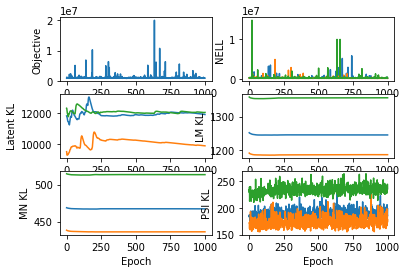

In [32]:
fitter.plot_log(log)

## Look at model fits

In [41]:
exam_mdl = 2

(120, 3)


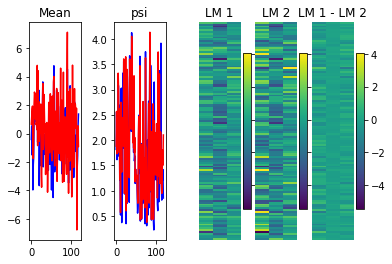

In [42]:
fit_lm = vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = vi_collections[exam_mdl].posteriors.psi_post(ind_props[exam_mdl]).detach().squeeze()

cmp_mdl = FAMdl(lm=fit_lm, mn=fit_mn, psi=fit_psi)
true_mdl = ind_true_fa_mdls[exam_mdl]

true_mdl.compare_models(true_mdl, cmp_mdl)

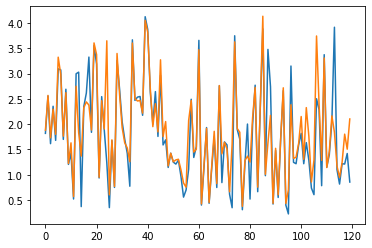

In [47]:
plt.plot(true_mdl.psi.detach().numpy())
plt.plot(cmp_mdl.psi.detach().numpy())